In [1]:
import os
from semantic_seg_model import inference
import image_helpers
from PIL import Image
import datasets as ds #import load_dataset
import re
import requests
from io import BytesIO

c:\Users\josie\Documents\dallESpeckleMap\AI_image_analyzer\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\josie\Documents\dallESpeckleMap\AI_image_analyzer\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
c:\Users\josie\Documents\dallESpeckleMap\AI_ima

In [2]:
## Directories

test_image_directory = "C:/Users/josie/OneDrive - Chalmers/Documents/Speckle hackathon/data/temp_test_image/"
processed_directory = test_image_directory + "processed/"
test_filename = os.listdir(test_image_directory)[1]
test_filename_root = test_filename.split('.')[0] + '_'
processed_filename = "processed/" + test_filename
processed_filename_root = "processed/" + test_filename_root
original_image_filepath = os.path.join(test_image_directory, test_filename)
processed_image_filepath = os.path.join(test_image_directory, processed_filename_root)

In [3]:
## Load embedding database (reconstruct for now)

from transformers import AutoModel, AutoFeatureExtractor
import torchvision.transforms as T
import torch
import random
import numpy as np

root_directory = "C:/Users/josie/OneDrive - Chalmers/Documents/Speckle hackathon/data/gold/"
dataset = ds.load_dataset("imagefolder", data_dir=root_directory, split="train")
dataset = dataset.add_column("filenames", os.listdir(root_directory + 'train/unlabeled/'))

model_ckpt = "nateraw/vit-base-beans" ## FIND DIFFERENT MODEL

extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

seed = 42
candidate_dataset = dataset.shuffle(seed=seed)

transformation_chain = T.Compose(
    [
        # We first resize the input image to 256x256 and then we take center crop.
        T.Resize(int((256 / 224) * extractor.size["height"])),
        T.CenterCrop(extractor.size["height"]),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
    ]
)

# Here, we map embedding extraction utility on our subset of candidate images.
batch_size = 24
device = "cuda" if torch.cuda.is_available() else "cpu"
extract_fn = image_helpers.extract_embeddings(transformation_chain, model.to(device))
candidate_subset_emb = candidate_dataset.map(extract_fn, batched=True, batch_size=24)

candidate_ids = []

for id in range(len(candidate_subset_emb)):
    # Create a unique indentifier.
    entry = str(id) + "_" + str(random.random()).split('.')[1]

    candidate_ids.append(entry)

all_candidate_embeddings = np.array(candidate_subset_emb["embeddings"])
all_candidate_embeddings = torch.from_numpy(all_candidate_embeddings)

# Save embeddings

c:\Users\josie\Documents\dallESpeckleMap\AI_image_analyzer\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\josie\Documents\dallESpeckleMap\AI_image_analyzer\.venv\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at nateraw/vit-base-beans and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 491/491 [00:04<00:00, 120.73 examples/s]


In [4]:
## Process test image

input_image = Image.open(original_image_filepath)

# Segment into parts
inference(input_image, savepath=processed_image_filepath)

# Convert images to grayscale
image_helpers.convert_images_to_grayscale(processed_directory)

# Crop to the largest contour
image_helpers.crop_center_largest_contour(processed_directory)

Generating train split: 3 examples [00:00, 1499.57 examples/s]


Similar material patches for ceiling
https://cdn.polyhaven.com/asset_img/thumbs/leather_white.png?width=256&height=256


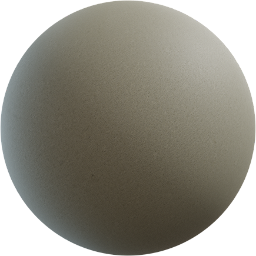

https://cdn.polyhaven.com/asset_img/thumbs/clay_floor_001.png?width=256&height=256


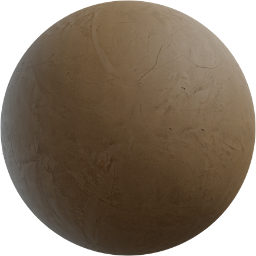

https://cdn.polyhaven.com/asset_img/thumbs/leather_red_03.png?width=256&height=256


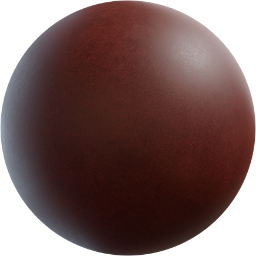

https://cdn.polyhaven.com/asset_img/thumbs/painted_plaster_wall.png?width=256&height=256


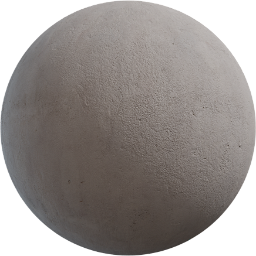

https://cdn.polyhaven.com/asset_img/thumbs/scuffed_cement.png?width=256&height=256


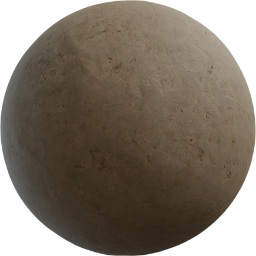


Similar material patches for floor
https://cdn.polyhaven.com/asset_img/thumbs/pavement_02.png?width=256&height=256


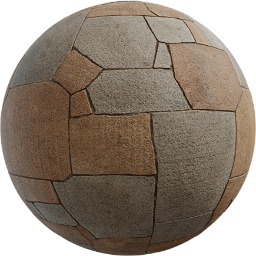

https://cdn.polyhaven.com/asset_img/thumbs/concrete_layers_02.png?width=256&height=256


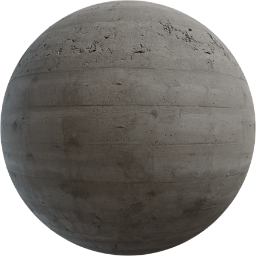

https://cdn.polyhaven.com/asset_img/thumbs/laminate_floor_02.png?width=256&height=256


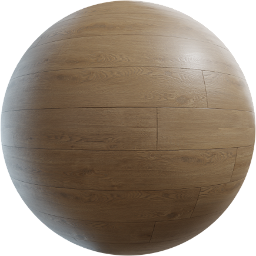

https://cdn.polyhaven.com/asset_img/thumbs/floor_tiles_04.png?width=256&height=256


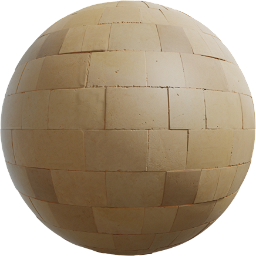

https://cdn.polyhaven.com/asset_img/thumbs/rosewood_veneer1.png?width=256&height=256


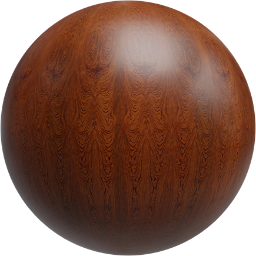


Similar material patches for wall
https://cdn.polyhaven.com/asset_img/thumbs/rusty_metal_02.png?width=256&height=256


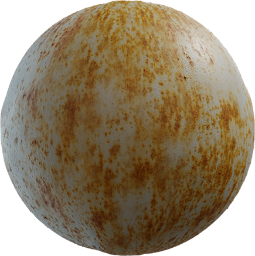

https://cdn.polyhaven.com/asset_img/thumbs/leather_white.png?width=256&height=256


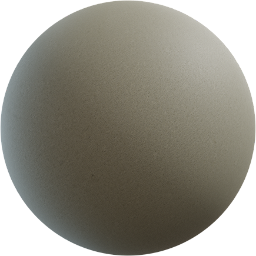

https://cdn.polyhaven.com/asset_img/thumbs/container_side.png?width=256&height=256


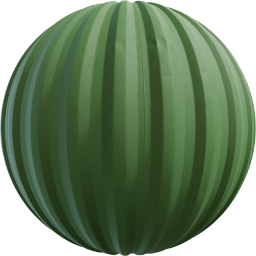

https://cdn.polyhaven.com/asset_img/thumbs/factory_wall.png?width=256&height=256


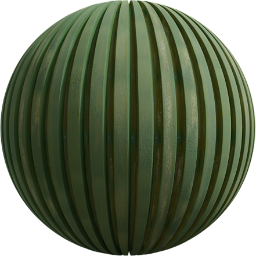

https://cdn.polyhaven.com/asset_img/thumbs/wood_table_worn.png?width=256&height=256


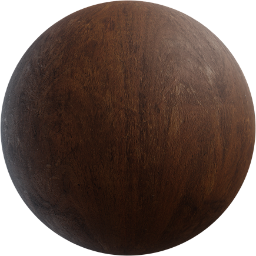

In [5]:
## Load processed test images and show similar material patches

test_ds = ds.load_dataset("imagefolder", data_dir=processed_directory)
label_filenames = ds.load_dataset("imagefolder", data_dir=processed_directory).cast_column("image", ds.Image(decode=False))

for i, each_component in enumerate(test_ds['train']):
    query_image = each_component["image"]
    component_label = label_filenames['train'][i]['image']['path'].split('_')[-1]
    component_label = re.match(r"([a-zA-Z]+)\d*\.png", component_label).group(1)
    print("Similar material patches for", component_label)
    sim_ids = image_helpers.fetch_similar(query_image, transformation_chain, device, model, all_candidate_embeddings, candidate_ids)
    for each_match in sim_ids:
        texture_filename = candidate_subset_emb[each_match]['filenames']
        image_url = f'https://cdn.polyhaven.com/asset_img/thumbs/{texture_filename}?width=256&height=256'
        print(image_url)
        response = requests.get(image_url)
        response.raise_for_status()  # Ensure the request was successful
        img = Image.open(BytesIO(response.content))
        display(img)
    print()
    